In [1]:
from ATARI.theory.resonance_statistics import make_res_par_avg
import ATARI.utils.hdf5 as h5io
from matplotlib.pyplot import *
import numpy as np
import pandas as pd
import importlib
import os
from copy import copy
from ATARI.sammy_interface import sammy_classes, sammy_functions, template_creator

from ATARI.ModelData.particle_pair import Particle_Pair
from ATARI.ModelData.experimental_model import Experimental_Model

from ATARI.ModelData.measurement_models.transmission_rpi import Transmission_RPI
from ATARI.ModelData.measurement_models.capture_yield_rpi import Capture_Yield_RPI
from ATARI.syndat.syndat_model import Syndat_Model
from ATARI.syndat.control import syndatOPT
from ATARI.syndat.control import Syndat_Control


In [2]:
%matplotlib widget

## AutoFit User Example

This notebook gives an examle how the ATARI.AutoFit module can be used to automatically fit data with no need for a prior.

In [3]:
def plot(datasets, experiments, fits=[], priors=[], true=[]):
    colors = ["C1", "C2", "C3", "C4", "C5", "C6", "C7"]
    fig, axes = subplots(2,1, figsize=(8,6), sharex=True)

    for i, exp in enumerate(experiments):
        if exp.reaction == "transmission":
            model_key = "theo_trans"
            iax = 0
        elif exp.reaction == "capture":
            model_key = "theo_xs"
            iax = 1
        else:
            raise ValueError()

        axes[iax].errorbar(datasets[i].E, datasets[i].exp, yerr=datasets[i].exp_unc, zorder=0,
                                                fmt='.', color=colors[i], linewidth=0.5, markersize=1.5, capsize=1, label=exp.title)
        
        if len(fits) != 0:
            axes[iax].plot(fits[i].E, fits[i][model_key], color=colors[i], lw=1.5, label=f'fit {exp.title}')
        if len(priors) != 0:
            axes[iax].plot(priors[i].E, priors[i][model_key], '--', color=colors[i], lw=1.5) #, label=f'prior {exp.title}')
        if len(true) != 0:
            axes[iax].plot(true[i].E, true[i]['true'], '-', color=colors[i], alpha=0.5, lw=1.5) #, label=f'prior {exp.title}')


        
    axes[0].set_ylabel("T")
    axes[1].set_ylabel(r"$Y_{\gamma}$")

    ### make it pretty
    for ax in axes:
        # ax.set_xlim([200,250])
        ax.set_ylim([-0.1,1.1])
        ax.legend()

    fig.supxlabel('Energy (eV)')
    fig.tight_layout()

    return fig

## First, generate data with Syndat to play with

In [6]:
### Reaction Model
Ta_pair = Particle_Pair(isotope = "Ta181",
                        resonance_ladder = pd.DataFrame(),
                        formalism = "XCT",
                        energy_range = [200,250],
                        ac = 8.127,
                        M = 180.94803,
                        I = 3,
                        l_max = 2
)

Ta_pair.add_spin_group(Jpi='3.0',
                       J_ID=1,
                       D_avg=8.79,
                       Gn_avg=46.5,
                       Gn_dof=1,
                       Gg_avg=64.0,
                       Gg_dof=1000)

Ta_pair.add_spin_group(Jpi='4.0',
                       J_ID=2,
                       D_avg=4.99,
                       Gn_avg=35.5,
                       Gn_dof=1,
                       Gg_avg=64.0,
                       Gg_dof=1000)

### Experimental Models
cap1mm_exp_gen = Experimental_Model(title = "cap1",
                                reaction ="capture", 
                                energy_range = [200, 250],
                                n = (0.005631, 0),
                                FP = (45.27, 0.05),
                                burst= (8.0,1.0), 
                                temp= (294.2610, 0.0),
                                channel_widths={
                                    "maxE": [270], 
                                    "chw": [102.7],
                                    "dchw": [0.8]
                                }
                               )

trans1mm_exp_gen = Experimental_Model(title = "trans1",
                               reaction = "transmission", 
                               energy_range = [200,250],
                                n = (0.00566,0.0),  
                                FP = (100.14,0.0), 
                                burst = (8, 0.0), 
                                temp = (294.2610, 0.0),
                               channel_widths={
                                    "maxE": [216.16, 613.02], 
                                    "chw": [204.7, 102.4],
                                    "dchw": [1.6, 1.6]
                                }
                               )

sammy_rto = sammy_classes.SammyRunTimeOptions('/Users/noahwalton/gitlab/sammy/sammy/build/bin/sammy',
                                        {"Print":   True,
                                         "bayes":   False,
                                         "keep_runDIR": False,
                                         "sammy_runDIR": "sammy_runDIR"
                                         })

template_creator.make_input_template('template_T.inp', Ta_pair, trans1mm_exp_gen, sammy_rto)
template_creator.make_input_template('template_Y.inp', Ta_pair, cap1mm_exp_gen, sammy_rto)


cap1mm_exp_gen.template = os.path.realpath('template_Y.inp')
trans1mm_exp_gen.template = os.path.realpath('template_T.inp')

### Measurement Models
cap1mm_meas_gen = Capture_Yield_RPI()
cap1mm_meas_red = Capture_Yield_RPI()

trans1mm_meas_gen = Transmission_RPI()
trans1mm_meas_red = Transmission_RPI()


### Syndat Models
options_cap1mm = syndatOPT(calculate_covariance=False)

syndat_cap1mm = Syndat_Model(cap1mm_exp_gen,
                            cap1mm_meas_gen,
                            cap1mm_meas_red,
                            options = options_cap1mm,
                            title='cap1mm')

options_trans1mm = syndatOPT(calculate_covariance = True)
syndat_trans1mm = Syndat_Model(trans1mm_exp_gen,
                            trans1mm_meas_gen,
                            trans1mm_meas_red,
                            options = options_trans1mm,
                            title='trans1mm')

In [7]:
### Control module for sampling from multiple syndat models

options_control = syndatOPT()
syndat = Syndat_Control(particle_pair= Ta_pair,
                        syndat_models= [syndat_trans1mm, syndat_cap1mm],
                        model_correlations=None,
                        options=options_control
                        )

syndat.sample(sammy_rto, num_samples=2)

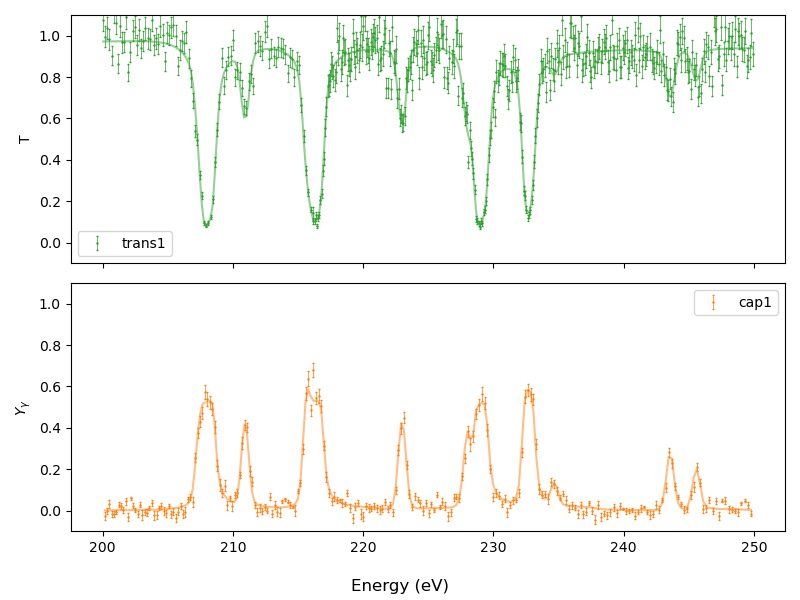

In [8]:
### unpack sample and plot

sample1 = syndat.get_sample(1)

datasets = [sample1['cap1mm'].pw_reduced, sample1['trans1mm'].pw_reduced]#, transdat3, transdat6]
experiments= [cap1mm_exp_gen, trans1mm_exp_gen]#, exptrans3, exptrans6]
covariance_data = [sample1['cap1mm'].covariance_data, sample1['trans1mm'].covariance_data]

fig = plot(datasets, experiments, fits=[], priors=[], true=datasets)
fig.tight_layout()

In [9]:
Ta_pair.spin_groups['3.0']

{'J_ID': 1,
 '<D>': 8.79,
 '<Gn>': 46.5,
 'n_dof': 1,
 '<Gg>': 64.0,
 'g_dof': 1000,
 'D01': 0.9943384234177864,
 'D99': 21.284662911191237,
 'Gn01': 0.007304585392801135,
 'Gn99': 308.52269194748646,
 'Gg01': 57.53039660349525,
 'Gg99': 70.84601563854191,
 'Gt01': 57.53770118888805,
 'Gt99': 379.3687075860284}

In [13]:
from ATARI.AutoFit.initial_FB_solve import InitialFB, InitialFBOPT


sammy_rto_fit = sammy_classes.SammyRunTimeOptions('/Users/noahwalton/gitlab/sammy/sammy/build/bin/sammy',
                                        {"Print":   True,
                                         "bayes":   True,
                                         "keep_runDIR": True,
                                         "sammy_runDIR": "sammy_runDIR"
                                         })


options = InitialFBOPT(Gn_threshold=1e-1)
autofit_initial = InitialFB(options)

In [14]:
outs = autofit_initial.fit(Ta_pair,
                               [200,250],
                               datasets,
                               experiments,
                               covariance_data,
                               sammy_rto_fit)

	FIT 1
Initial solve from 124 resonance features

Stepping until convergence
chi2 values
step fudge: ['cap1', 'trans1', 'sum']
0    0.5  : [52.0744, 282.668, 334.7424]
1    0.75 : [12.3865, 33.6758, 46.0623]
2    1.125: [6.9228, 4.3201, 11.2429]
Repeat step 3, 	fudge: ['cap1', 'trans1', 'sum']
		0.75 : [11.2674, 6.3197, 17.5871]
		0.5  : [9.8764, 5.7555, 15.6319]
		0.333: [5.4158, 4.3365, 9.7523]
3    0.333: [5.4158, 4.3365, 9.7523]
4    0.5  : [5.2711, 4.356, 9.6271]
5    0.75 : [5.2331, 4.3149, 9.548]
Chi2 improvement below threshold

----------------------------------------
Eliminated 59.68% of resonance features based on neuton width
Resolving with 50 resonance features
----------------------------------------

Stepping until convergence
chi2 values
step fudge: ['cap1', 'trans1', 'sum']
0    0.5  : [5.2142, 4.3995, 9.6138]
1    0.75 : [5.3578, 4.2509, 9.6087]
Chi2 improvement below threshold

Complete after no neutron width features below threshold

	FIT 2
Initial solve from 50 res

In [15]:
final_fb_output = outs[-1]
len(final_fb_output.par_post)


45

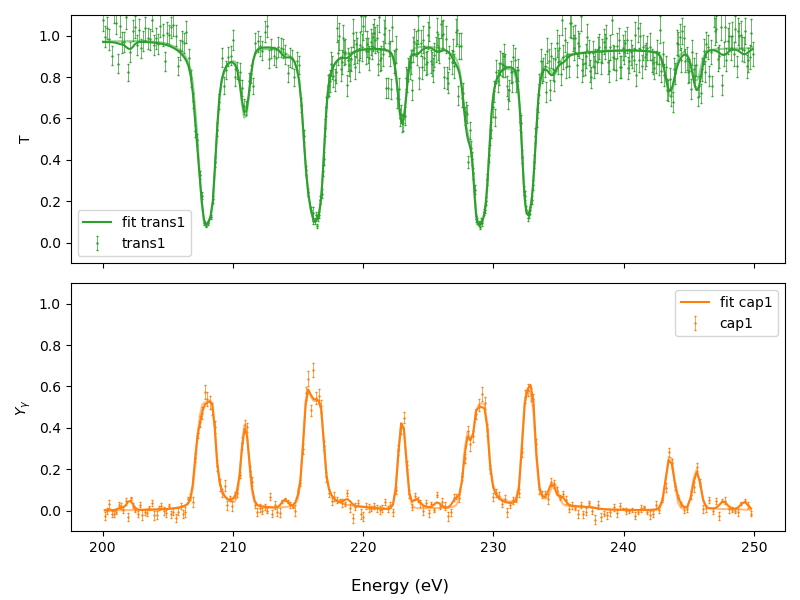

In [16]:
fig = plot(datasets, experiments, fits=final_fb_output.pw_post, priors=[], true=datasets)
fig.tight_layout()

In [17]:
Ta_pair.resonance_ladder # number of res true

,E,Gg,Gn1,J,J_ID,varyE,varyGg,varyGn1
0,207.435714,66.663046,5.632291,3.0,1,0.0,0.0,0.0
1,216.418133,67.297556,87.446304,3.0,1,0.0,0.0,0.0
2,228.009878,68.305555,7.682922,3.0,1,0.0,0.0,0.0
3,232.697169,60.236719,63.530736,3.0,1,0.0,0.0,0.0
4,243.56417,61.023956,6.519745,3.0,1,0.0,0.0,0.0
5,246.754811,65.107212,0.036668,3.0,1,0.0,0.0,0.0
6,208.086136,70.14255,87.922579,4.0,2,0.0,0.0,0.0
7,210.934398,60.271685,6.563034,4.0,2,0.0,0.0,0.0
8,215.738257,66.493438,11.828776,4.0,2,0.0,0.0,0.0
9,222.991731,62.88378,8.029438,4.0,2,0.0,0.0,0.0


In [19]:
final_fb_output.par_post

,E,Gg,Gn1,varyE,varyGg,varyGn1,J_ID
0,201.399880,36.520179,0.136389,1.0,1.0,1.0,1.0
1,202.088201,26.533824,0.602286,1.0,1.0,1.0,1.0
2,207.435733,42.963487,0.947898,1.0,1.0,1.0,1.0
3,208.086185,81.183512,101.203112,1.0,1.0,1.0,1.0
4,210.361867,182.600480,0.734443,1.0,1.0,1.0,1.0
5,210.963242,40.344549,1.627251,1.0,1.0,1.0,1.0
6,215.208521,19.934811,0.681832,1.0,1.0,1.0,1.0
7,216.433419,62.837784,84.957400,1.0,1.0,1.0,1.0
8,218.781349,47.487226,0.230491,1.0,1.0,1.0,1.0
9,222.978654,52.040022,7.650924,1.0,1.0,1.0,1.0


# AutoFit Module

# Elim Module

In [20]:
settings = {
    'path_to_SAMMY_exe': '/Users/noahwalton/gitlab/sammy/sammy/build/bin/sammy',
    'path_to_SAMMY_temps': './sammy_temps/',
    'keep_runDIR_SAMMY': False,
    'shell_SAMMY': 'bash',
    'delta_chi2_per_res': 28
}

keep_fixed = True
case_id = 0

delta_chi2_allowed = settings['delta_chi2_per_res']
# save_to_folder = './proc_cases/'

In [23]:
import importlib

# defining a start ladder to eliminate from

from ATARI.AutoFit import chi2_eliminator

importlib.reload(chi2_eliminator)
# Re-import the function from the reloaded module

start_ladder = final_fb_output.par_post
assert isinstance(start_ladder, pd.DataFrame)
# side resonances - keep empty
side_resonances_df = pd.DataFrame()

# defining rto & inputs

elim_rto = sammy_classes.SammyRunTimeOptions(
    sammyexe = settings['path_to_SAMMY_exe'],
    options = {"Print":   True,
                "bayes":   False,
                "keep_runDIR": settings['keep_runDIR_SAMMY'],
                "sammy_runDIR": f"sammy_RD_{case_id}"
                }
)

elim_sammyINPyw = sammy_classes.SammyInputDataYW(
    particle_pair = Ta_pair,
    resonance_ladder = start_ladder,

    datasets = datasets,
    experimental_covariance=covariance_data,
    experiments = experiments,

    max_steps = 0,
    iterations = 2,
    step_threshold = 0.01,
    autoelim_threshold = None,

    LS = False,
    LevMar = True,
    LevMarV = 1.5,

    minF = 1e-5,
    maxF = 10,
    initial_parameter_uncertainty = 0.1
    )

# defining the elim_opts
elim_opts = chi2_eliminator.elim_OPTs(chi2_allowed = delta_chi2_allowed,
                                      fixed_resonances_df = side_resonances_df,
                                      deep_fit_max_iter = 5,
                                      deep_fit_step_thr = 0.01,
                                      start_fudge_for_deep_stage = 0.1
                                      )

In [22]:
elimi = chi2_eliminator.eliminator_by_chi2(rto=elim_rto,
                 sammyINPyw = elim_sammyINPyw , 
                 options = elim_opts
)


In [24]:
# a try to fit using wrapper - note varying parameters are set in start_ladder
unique_combinations = start_ladder[['varyE', 'varyGg', 'varyGn1']].drop_duplicates()
print(unique_combinations)

sammyOUT, fit_time = elimi.fit_YW_by_ig(ladder_df = start_ladder,
                                        max_steps=10,
                                        step_threshold=0.01)

   varyE  varyGg  varyGn1
0    1.0     1.0      1.0
Stepping until convergence
chi2 values
step fudge: ['cap1', 'trans1', 'sum']
0    0.1  : [1.8045, 2.0566, 3.8611]
1    0.15 : [1.7968, 2.0585, 3.8553]
Chi2 improvement below threshold


In [25]:
# now let's eliminate one by one - using the simplified alg - and note  1) allowing to fit all during the deep fit stage
hist = elimi.eliminate(ladder_df=sammyOUT.par_post)

****************************************
Elimination cycle printout enabled
****************************************

Chi2 thresold applied for model selection: 28


Input ladder:
             E          Gg         Gn1  varyE  varyGg  varyGn1  J_ID
0   201.399989   36.486221    0.136461    1.0     1.0      1.0   1.0
1   202.088397   26.464360    0.602304    1.0     1.0      1.0   1.0
2   207.436039   42.934645    0.949548    1.0     1.0      1.0   1.0
3   208.086182   81.164513  101.213195    1.0     1.0      1.0   1.0
4   210.359045  182.408584    0.732082    1.0     1.0      1.0   1.0
5   210.907071   40.321315    1.630307    1.0     1.0      1.0   1.0
6   215.204235   19.893536    0.682532    1.0     1.0      1.0   1.0
7   216.433440   62.721286   84.964757    1.0     1.0      1.0   1.0
8   218.781403   47.467853    0.230480    1.0     1.0      1.0   1.0
9   222.999976   52.105138    7.640614    1.0     1.0      1.0   1.0
10  224.106138   47.673958    0.395906    1.0     1.0      1.

In [26]:
print(f'Eliminated from {hist.ladder_IN.shape[0]} res -> {hist.ladder_OUT.shape[0]}')
print('Final ladder:')
print(hist.ladder_OUT)
print(hist.elimination_history.keys())

Eliminated from 45 res -> 16
Final ladder:
             E          Gg         Gn1  Gn2  Gn3  varyE  varyGg  varyGn1  \
0   202.073608   21.109441    0.621928  0.0  0.0    1.0     1.0      1.0   
1   208.085175   81.756536  101.186122  0.0  0.0    1.0     1.0      1.0   
2   216.416907   67.146845   89.382467  0.0  0.0    1.0     1.0      1.0   
3   228.001220   34.795417    7.394521  0.0  0.0    1.0     1.0      1.0   
4   229.011391   77.945963  110.269991  0.0  0.0    1.0     1.0      1.0   
5   234.603075  236.770716    2.435585  0.0  0.0    1.0     1.0      1.0   
6   243.571295  183.888836    6.642801  0.0  0.0    1.0     1.0      1.0   
7   249.259611   23.829984    0.742464  0.0  0.0    1.0     1.0      1.0   
8   207.350093   16.667939    4.551019  0.0  0.0    1.0     1.0      1.0   
9   210.936151  131.677910    6.579532  0.0  0.0    1.0     1.0      1.0   
10  213.984319   14.497000    0.401474  0.0  0.0    1.0     1.0      1.0   
11  215.733353   69.640821   11.387160  0.0  

In [27]:
final_fb_output.pw_post

[              E    exp_xs  exp_xs_unc   theo_xs  theo_xs_bayes  exp_trans  \
 0    200.176298 -0.026289    0.017644  0.001478            NaN        NaN   
 1    200.354155 -0.003802    0.013971  0.001557            NaN        NaN   
 2    200.532249  0.032417    0.018738  0.001671            NaN        NaN   
 3    200.710580 -0.017324    0.013690  0.001968            NaN        NaN   
 4    200.889150 -0.015826    0.014135  0.003085            NaN        NaN   
 ..          ...       ...         ...       ...            ...        ...   
 232  248.785641 -0.008897    0.018451  0.015104            NaN        NaN   
 233  249.032087  0.034636    0.005604  0.031857            NaN        NaN   
 234  249.278900  0.047530    0.006734  0.041503            NaN        NaN   
 235  249.526080  0.026168    0.014732  0.027341            NaN        NaN   
 236  249.773628 -0.014085    0.012577  0.010439            NaN        NaN   
 
      exp_trans_unc  theo_trans  theo_trans_bayes  
 0        

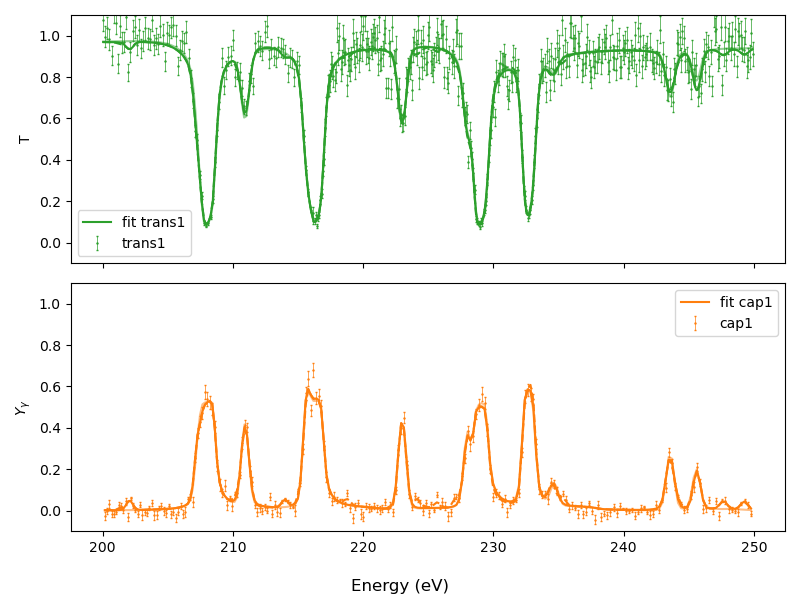

In [28]:
# hist.ladder_OUT
minkey = min(hist.elimination_history.keys())

outfit = hist.elimination_history[minkey]['selected_ladder_chars'].pw
# outfit
fig = plot(datasets, experiments, fits=outfit, priors=final_fb_output.pw_post, true=datasets)
fig.tight_layout()

In [29]:
minkey

16

In [ ]:

# now let's eliminate one by one - using the simplified alg - and note 2) allowing to fit only E and Gn1 during the deep fit stage
